# 2.0 Machine Learning Pipeline

The pipeline will involve the following models:

- Decision Tree
- Regression
- Random Forest
- Gradient-boosted trees
- Naive Bayes

Here's our recipe for success:

1. Load the data
2. Split the data using the 80/20 approach
3. Select feature columns and vectorize them
4. Instantiate models
5. Build and run the pipeline
6. Apply metrics such as accuracy, precision, recall, and f1-score

Documentation:

- [Apache Spark ML Pipeline](https://spark.apache.org/docs/latest/ml-pipeline.html)
- [Decision Tree Classifier](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)
- [F1-Score Guide](https://www.v7labs.com/blog/f1-score-guide)
- [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
- [PySpark ML with Text (Part 1)](https://datascience-enthusiast.com/Python/PySpark_ML_with_Text_part1.html)

In [17]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import PySpark libraries
from pyspark.sql import Window
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Configure Spark Session
spark = SparkSession.builder \
    .appName("Credit Card ML") \
    .config("spark.master", "local") \
    .getOrCreate()
sc = spark.sparkContext

In [3]:
# Load file
df = spark.read.csv('datasets/creditcard.csv', header=True, inferSchema=True, sep=",")

In [4]:
# Select fraud and non-fraud transactions and limit non-fraud transactions to the same number as fraud transactions
fraud_df = df.filter(f.col('Class') == 1)
non_fraud_df = df.filter(f.col('Class') == 0).limit(fraud_df.count())

# Combine fraud and non-fraud transactions and shuffle the data
balanced_df = fraud_df.union(non_fraud_df).orderBy(f.rand())

# Show 10 rows of the shuffled, balanced dataframe
balanced_df.limit(10).toPandas()

23/04/30 08:36:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,135095.0,0.232512,0.938944,-4.647780,3.079844,-1.902655,-1.041408,-1.020407,0.547069,-1.105990,...,0.911373,1.042929,0.999394,0.901260,-0.452093,0.192959,0.180859,-0.029315,345.00,1
1,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
2,160870.0,-0.644278,5.002352,-8.252739,7.756915,-0.216267,-2.751496,-3.358857,1.406268,-4.403852,...,0.587728,-0.605759,0.033746,-0.756170,-0.008172,0.532772,0.663970,0.192067,0.77,1
3,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,...,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0
4,91.0,-1.822273,1.235336,-0.307804,-1.821824,2.762482,3.641499,-0.344614,-1.547541,-0.138239,...,2.080848,-1.591888,0.321636,0.889258,0.156445,-0.960611,-0.035302,0.182321,15.89,0
5,91554.0,-5.100256,3.633442,-3.843919,0.183208,-1.183997,1.602139,-3.005953,-8.645038,1.285458,...,8.280439,-2.797150,1.090707,-0.159260,0.532156,-0.497126,0.943622,0.553581,261.22,1
6,142280.0,-1.169203,1.863414,-2.515135,5.463681,-0.297971,1.364918,0.759219,-0.118861,-2.293921,...,-0.393090,-0.708692,0.471309,-0.078616,-0.544655,0.014777,-0.240930,-0.781055,324.59,1
7,95.0,1.195572,0.258858,0.635796,0.641257,-0.395081,-0.694667,0.034086,-0.124346,-0.078400,...,-0.201249,-0.516925,0.199096,0.412552,0.122984,0.101940,-0.007846,0.020214,1.29,0
8,303.0,1.254258,1.218376,-2.148615,1.155957,1.813892,-0.238358,0.623888,-0.060265,-0.739258,...,-0.210083,-0.463849,-0.370852,-1.644707,0.962670,-0.200548,0.055746,0.071654,2.95,0
9,307.0,-2.658288,-3.014776,2.271636,-1.218204,1.546541,-1.682064,-1.524913,0.088425,-0.761266,...,-0.212736,-0.587618,0.320804,-0.013227,-0.233772,0.742313,-0.505256,0.394053,52.90,0


In [5]:
# build a data split: 80/20
train, test = .lambda .randomSplit(weights=[0.8, 0.2], seed=42)
print('Train shape: ', (train.count(), len(train.columns)))
print('Test shape: ', (test.count(), len(test.columns)))

Train shape:  (825, 31)


Test shape:  (159, 31)


In [6]:
# get feature columns names
feature_columns = [col for col in balanced_df.columns if col!= 'Class']
print(feature_columns)
print(len(feature_columns))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
30


In [7]:
# vectorize
vectorizer = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_vec = vectorizer.transform(train)
test_vec = vectorizer.transform(test)

train_vec.select('Time','Features','Class').show(10)

+----+--------------------+-----+
|Time|            Features|Class|
+----+--------------------+-----+
| 0.0|[0.0,-1.359807133...|    0|
| 0.0|[0.0,1.1918571113...|    0|
| 1.0|[1.0,-0.966271711...|    0|
| 2.0|[2.0,-1.158233093...|    0|
| 2.0|[2.0,-0.425965884...|    0|
| 7.0|[7.0,-0.894286082...|    0|
| 9.0|[9.0,-0.338261752...|    0|
|10.0|[10.0,0.384978215...|    0|
|10.0|[10.0,1.249998742...|    0|
|10.0|[10.0,1.449043781...|    0|
+----+--------------------+-----+
only showing top 10 rows



In [8]:
# instantiate Models

# regression
lr = LogisticRegression(
    featuresCol='features',
    labelCol='Class',
    predictionCol='Class_Prediction',
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8
)
# decison tree
dt = DecisionTreeClassifier(featuresCol='features',
                            labelCol='Class',
                            predictionCol='Class_Prediction'
                            )
# random forest
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='Class',
    predictionCol='Class_Prediction'
)
# gradient - boosted tree
gbt = GBTClassifier(
    featuresCol='features',
    labelCol='Class',
    predictionCol='Class_Prediction'
)
# linear support vector machines
lsvc = LinearSVC(
    featuresCol='features',
    labelCol='Class',
    predictionCol='Class_Prediction'
)

# create list of models
list_of_models = [lr, dt, rf, gbt, lsvc]
list_of_model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient-Boosted Tree', 'Linear Support Vector Machines']

# go through list
for model, model_name in zip(list_of_models, list_of_model_names):

    # print current model
    print('Current model: ', model_name)

    # create a pipeline object
    pipeline = Pipeline(stages=[model])

    # fit pipeline
    pipeline_model = pipeline.fit(train_vec)

    # get scores on the test set
    test_pred = pipeline_model.transform(test_vec)


    # get accuracy on test set
    accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol='Class_Prediction', labelCol='Class', metricName='accuracy')
    accuracy_score = accuracy_evaluator.evaluate(test_pred)
    print('Accuracy: ', accuracy_score)

    # get precision on test set
    precision_evaluator = MulticlassClassificationEvaluator(predictionCol='Class_Prediction', labelCol='Class', metricName='precisionByLabel')
    precision_score = precision_evaluator.evaluate(test_pred)
    print('Precision: ', precision_score)

    # get recall on test set
    recall_evaluator = MulticlassClassificationEvaluator(predictionCol='Class_Prediction', labelCol='Class', metricName='recallByLabel')
    recall_score = recall_evaluator.evaluate(test_pred)
    print('Recall: ', recall_score)

    # get f1-score on test set
    f1_evaluator = MulticlassClassificationEvaluator(predictionCol='Class_Prediction', labelCol='Class', metricName='f1')
    f1_score = f1_evaluator.evaluate(test_pred)
    print('F1-score: ', f1_score)

Current model:  Logistic Regression


23/04/30 08:37:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/30 08:37:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Accuracy:  0.9245283018867925


Precision:  0.8588235294117647


Recall:  1.0


F1-score:  0.9245641270599474
Current model:  Decision Tree


Accuracy:  1.0


Precision:  1.0


Recall:  1.0


F1-score:  1.0
Current model:  Random Forest


Accuracy:  1.0


Precision:  1.0


Recall:  1.0


F1-score:  1.0
Current model:  Gradient-Boosted Tree


Accuracy:  1.0


Precision:  1.0


Recall:  1.0


F1-score:  1.0
Current model:  Linear Support Vector Machines


Accuracy:  0.9874213836477987


Precision:  0.9733333333333334


Recall:  1.0


F1-score:  0.9874323824379319


As expected when working with an imbalanced, binary-targeted dataset, the predictions have excellent values for every metric. This happens because, in this particular case, 99% of records have a value of '0 - not fraud', which means that the model is basically training to predict 0s most of the time.

## 2.2 Feature Selection

In [11]:
df1_new = balanced_df.toPandas()
df1_new.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,135095.0,0.232512,0.938944,-4.647780,3.079844,-1.902655,-1.041408,-1.020407,0.547069,-1.105990,...,0.911373,1.042929,0.999394,0.901260,-0.452093,0.192959,0.180859,-0.029315,345.00,1
1,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
2,160870.0,-0.644278,5.002352,-8.252739,7.756915,-0.216267,-2.751496,-3.358857,1.406268,-4.403852,...,0.587728,-0.605759,0.033746,-0.756170,-0.008172,0.532772,0.663970,0.192067,0.77,1
3,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,...,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0
4,91.0,-1.822273,1.235336,-0.307804,-1.821824,2.762482,3.641499,-0.344614,-1.547541,-0.138239,...,2.080848,-1.591888,0.321636,0.889258,0.156445,-0.960611,-0.035302,0.182321,15.89,0


## Correlation Coefficient Method

Correlation is a measure of the linear relationship between 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that good variables correlate highly with the target. Furthermore, variables should be correlated with the target but uncorrelated among themselves.

If two variables are correlated, we can predict one from the other. Therefore, if two features are correlated, the model only needs one, as the second does not add additional information. We will use the Pearson Correlation here.


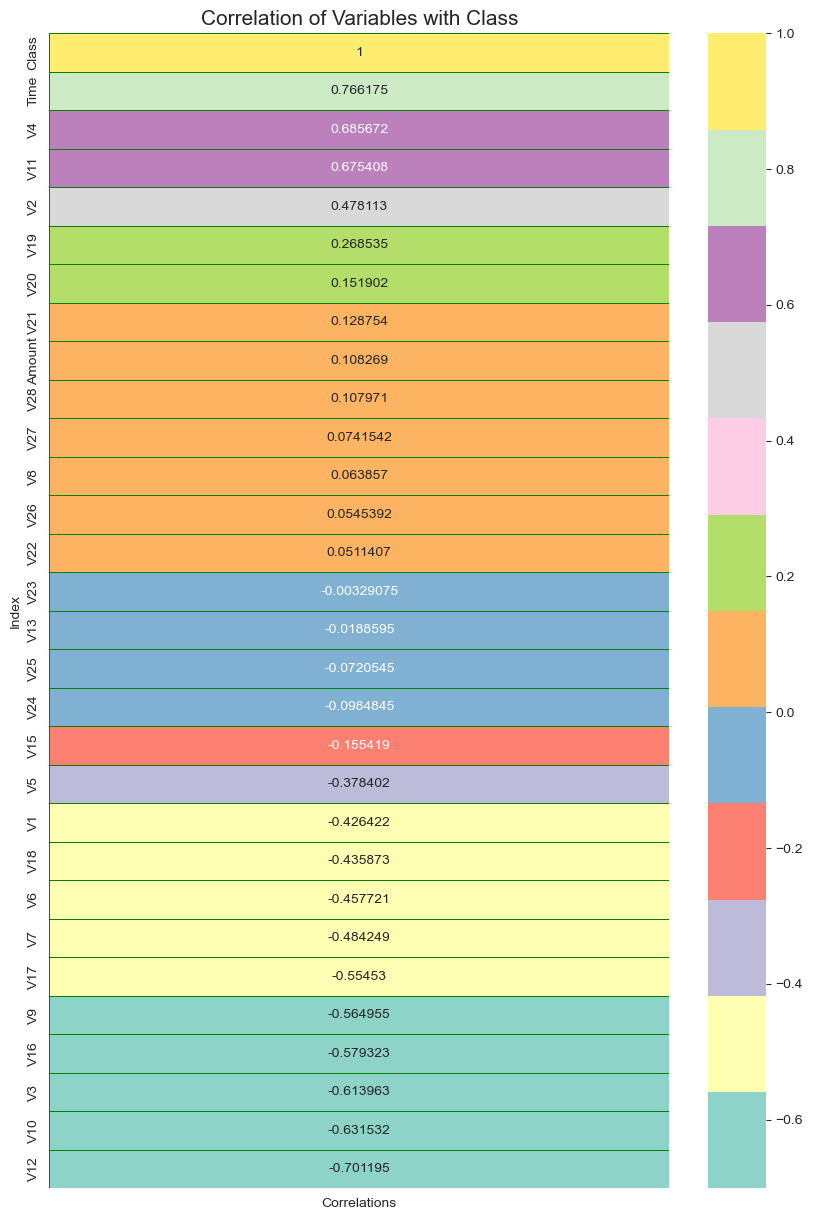

In [12]:
corr = df1_new.corrwith(df1_new['Class'],method='pearson').reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False).head(30)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Correlation of Variables with Class", fontsize=15)
plt.show();

##  Kbest Select Method

Select features according to the k highest scores.

In [15]:
X = df1_new.drop(['Class'],axis = 1)
target = df1_new['Class']
target_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size= 0.3, random_state = 42)

In [18]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=29)
fit = bestfeatures.fit(X,target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
print(featureScores.nlargest(23,'Score'))

   Feature     Score
0     Time  0.682922
12     V12  0.477646
3       V3  0.476113
14     V14  0.467275
10     V10  0.465325
17     V17  0.444741
11     V11  0.370606
4       V4  0.370422
16     V16  0.341620
7       V7  0.322072
2       V2  0.320593
9       V9  0.285274
21     V21  0.253344
1       V1  0.236562
6       V6  0.235414
27     V27  0.232329
18     V18  0.226863
29  Amount  0.210029
5       V5  0.187593
28     V28  0.176904
8       V8  0.160720
19     V19  0.141317
20     V20  0.122468


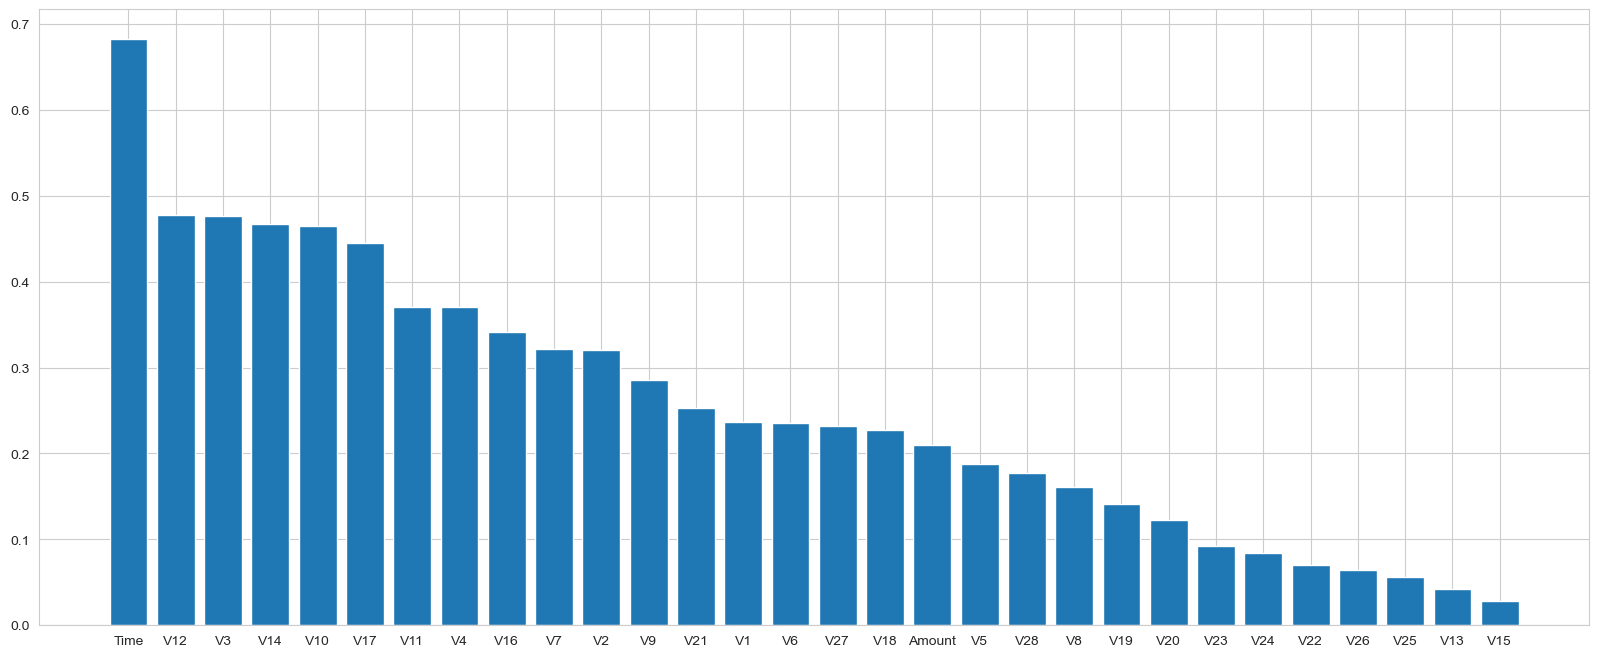

In [20]:
plt.figure(figsize=(20,8))
featureScores2 = featureScores.sort_values('Score', ascending=False)
plt.bar("Feature", "Score", data=featureScores2)
plt.show();

## Mutual Information Classification Method

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [ ]:
# determine the mutual information
mutual_info = mutual_info_classif(X_train, Y_train)
mutual_info = pd.Series(mutual_info)
dfcolumns = pd.DataFrame(X.columns)
feature_score3 = pd.concat([dfcolumns,mutual_info],axis=1)
feature_score3.columns = ['Feature','Score']
print(feature_score3.nlargest(28,'Score'))

## 2.3 Hyperparameter tuning with CrossValidator

In [ ]:
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 4, 5])
               .addGrid(rf.numTrees, [5, 10, 20, 100])
               .build())

In [ ]:
evaluatorRF=BinaryClassificationEvaluator(labelCol='Class')

cv = CrossValidator(estimator = rf,
                    estimatorParamMaps = rfparamGrid,
                    evaluator = evaluatorRF,
                    numFolds = 5)

rfcv=cv.fit(test_pred)